# 4. Classification – Applied

Excercises from **Chapter 4** of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

I've elected to use Python instead of R.

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML

## 10. This question should be answered using the Weekly data set, which is part of the ISLR package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

### (a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [2]:
# Load data
weekly_df = pd.read_csv('./data/Weekly.csv')

# Check for missing data
assert weekly_df.isnull().sum().sum() == 0

# Pre-processing
weekly_df = pd.get_dummies(weekly_df).drop('Direction_Down', axis=1)
weekly_df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,1


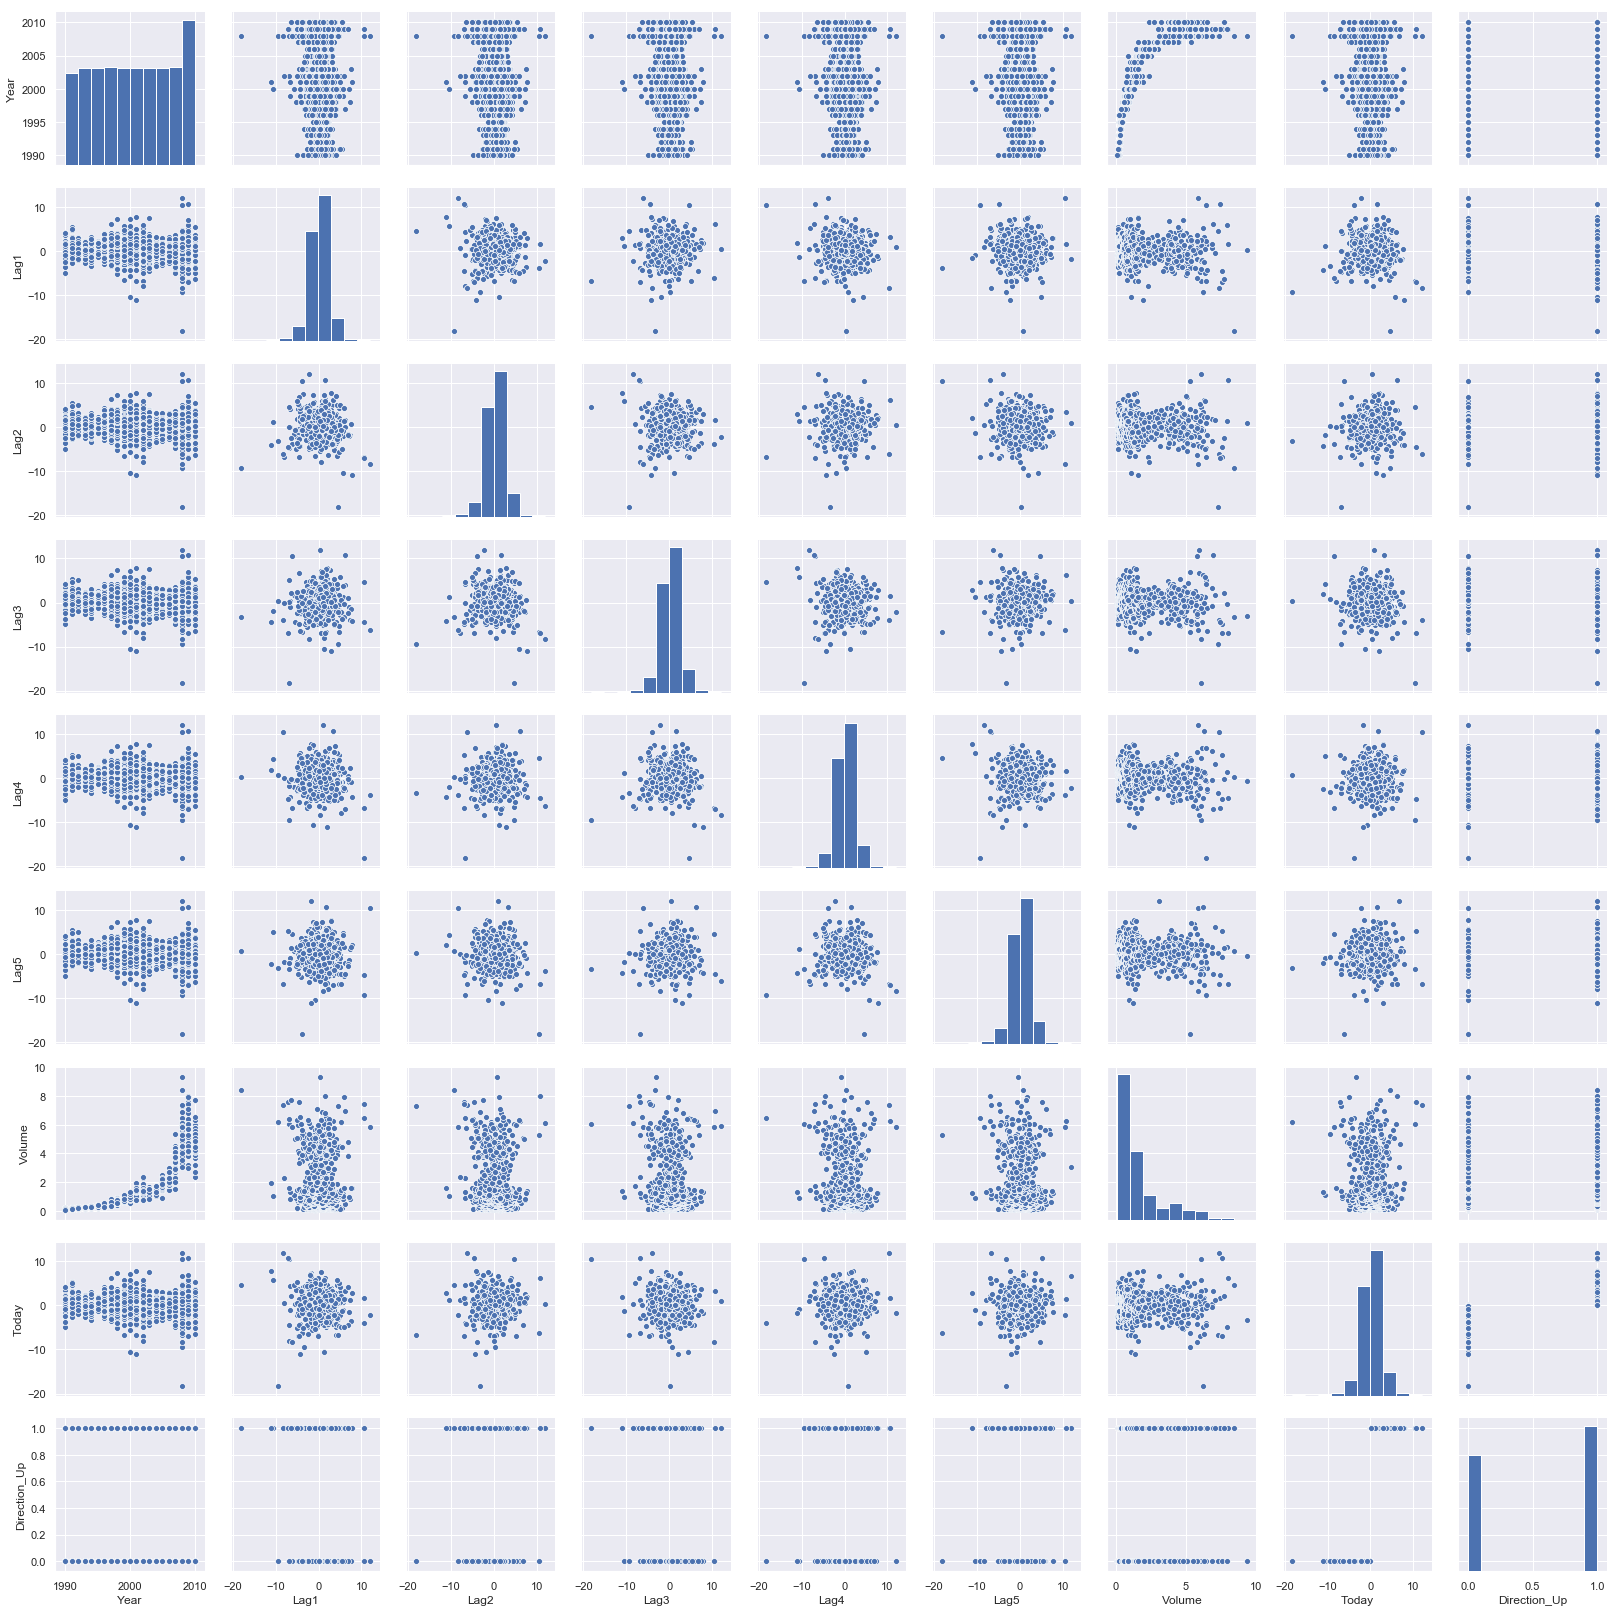

In [3]:
# Pairplot
sns.pairplot(weekly_df);

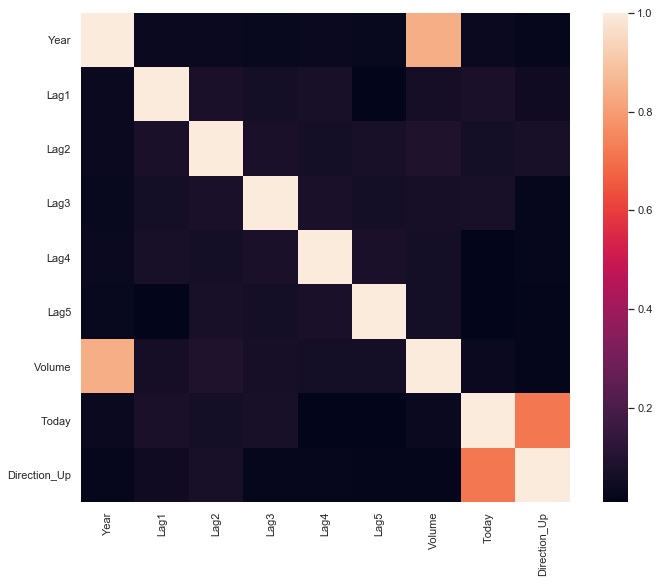

In [4]:
# Correlation matrix
corr_matrix = weekly_df.corr().abs()
fig, ax     = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

The correlation matrix above shows that only 2 pairs of features are correlated:

- Year – Volume
- Today – Direction_UP

Looking at the pairplot above suggests:
- Volume increases exponentially with Year
- There is a logistic relationship between Today and Direction_Up




### (b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [5]:
# Fit model
f_10b = 'Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'
model_10b = smf.Logit.from_formula(formula=f_10b, data=weekly_df).fit()
# Display model summary
display(model_10b.summary())

# Do any of the predictors appear to be statistically significant?
display(HTML('<h3>Statistically significant predictors:</h3>'))
display(pd.DataFrame({'p>|z|': model_10b.pvalues[model_10b.pvalues < 0.05].drop('Intercept')}))

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Direction_Up   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Sat, 15 Sep 2018   Pseudo R-squ.:                0.006580
Time:                        16:25:30   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
                                        LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

,p>|z|
Lag2,0.029601


### (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [6]:
# Clarifying orientation of confusion matrix
# Here we see that 
# - rows i represent true values
# - columns j represent predictions


y_true = [1, 0, 1, 1, 0, 1]
y_pred = [0, 0, 1, 1, 0, 1]

confusion_matrix(y_true, y_pred)

array([[2, 0],
       [1, 3]])

In [87]:
def confusion_table(confusion_mtx):
    """Renders a nice confusion table with labels"""
    display(HTML('<h4>Confusion Table</h4>'))
    confusion_df = pd.DataFrame({'y_pred=0': np.append(confusion_mtx[:, 0], confusion_mtx.sum(axis=0)[0]),
                                 'y_pred=1': np.append(confusion_mtx[:, 1], confusion_mtx.sum(axis=0)[1]),
                                 'Total': np.append(confusion_mtx.sum(axis=1), ''),
                                 '': ['y=0', 'y=1', 'Total']}).set_index('')
    return confusion_df


def positive_observations(y):
    # What percentage of observations are positive?
    proportion_1 = ((y == 1).sum() / len(y))
    pct_1        = np.around(proportion_1*100, decimals=3)
    display(HTML('<p><h4>{}%</h4>of observations are positive</p>'.format(pct_1)))


# Classifier stats
# -------------------------------------------------

def prior_error_rate(confusion_matrix):
    """The prior probability that a result is positive"""
    return 1 - (np.sum(confusion_mtx[1, :]) / np.sum(confusion_mtx))

def total_error_rate(confusion_matrix):
    """Derive total error rate from confusion matrix"""
    return 1 - np.trace(confusion_mtx) / np.sum(confusion_mtx)

def true_positive_rate(confusion_mtx):
    """or sensitivity: the proportion of actual POSITIVES that are correctly identified as such"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[1, :])

def false_negative_rate(confusion_mtx):
    """the proportion of actual POSITIVES that are incorrectly identified as negative"""
    return confusion_mtx[1, 0] / np.sum(confusion_mtx[1, :])

def false_positive_rate(confusion_mtx):
    """the proportion of actual NEGATIVES that are incorrectly identified as positives"""
    return confusion_mtx[0, 1] / np.sum(confusion_mtx[0, :])

def true_negative_rate(confusion_mtx):
    """or specificity: the proportion of actual NEGATIVES that are correctly identified as such"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[0, :])

def positive_predictive_value(confusion_mtx):
    """or precision: the proportion of predicted positives that are correctly predicted"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[:, 1])

def negative_predictive_value(confusion_mtx):
    """the proportion of predicted negatives that are correctly predicted"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])

def classifier_stats(confusion_mtx):
    return pd.Series({'prior_error_rate': prior_error_rate(confusion_mtx),
                      'total_error_rate': total_error_rate(confusion_mtx),
                      'true_positive_rate (sensitivity)': true_positive_rate(confusion_mtx),
                      'false_negative_rate': false_negative_rate(confusion_mtx),
                      'false_positive_rate': false_positive_rate(confusion_mtx),
                      'true_negative_rate (specificity)': true_negative_rate(confusion_mtx),
                      'positive_predictive_value (precision)': positive_predictive_value(confusion_mtx),
                      'negative_predictive_value': negative_predictive_value(confusion_mtx)})


In [88]:
# Get confusion matrix
confusion_mtx = model_10b.pred_table(threshold=0.5)

# Render as nice table
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - error_rate(confusion_mtx)
print('fraction of predictions correct: \n' + str(np.round(correct_rate, 5)))

,y_pred=0,y_pred=1,Total
,,,
y=0,54.0,430.0,484.0
y=1,48.0,557.0,605.0
Total,102.0,987.0,


fraction of predictions correct: 
0.56107


In [89]:
classifier_stats(confusion_mtx)

prior_error_rate                         0.444444
total_error_rate                         0.438935
true_positive_rate (sensitivity)         0.920661
false_negative_rate                      0.079339
false_positive_rate                      0.888430
true_negative_rate (specificity)         0.111570
positive_predictive_value (precision)    0.564336
negative_predictive_value                0.529412
dtype: float64

In [90]:
# What percentage of observations are in the direction_up class?
positive_observations(weekly_df['Direction_Up'])

- Overall the model got 56.1% of predictions correct. This is marginally better than naively predicting that all observations will yield a return which we would expect to yield 55.6% correct predictions.
- 92% senstivity tells us that 92% of that stocks *actually* yield a return were predicted correctly
- Our model is much worse at predicting **no** dividends (a decrease in stock), this shown by a specificity of only 11% – only 11% of our models predictions for Direction_Up = 0 were correct. 
- The above translates to a high false positive rate of  89% – 89% of negative results were predicted as positive. 

Our model predicts a high proportion of the true positive observations correctly (92% true positive rate), but it also predicts a high proportion of true negative results incorrectly (11% true negative rate).

This model might be more useful for predicting which stocks to invest in if we could reduce the rate of false positive results.

### (d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [121]:
# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)
y_test          = weekly_df_test['Direction_Up']


# What percentage of observations are in the direction_up class?
positive_observations(weekly_df_test['Direction_Up'])

# Fit model
f_10d     = 'Direction_Up ~ Lag2'
model_10d = smf.Logit.from_formula(formula=f_10d, data=weekly_df_train).fit()

# Get confusion matrix using test data
threshold     = 0.5
y_pred_logit   = (model_10d.predict(weekly_df_test) > threshold).astype(int)
confusion_mtx = confusion_matrix(y_test, y_pred_logit)

# Render as nice table
display(confusion_table(confusion_mtx))

# Classifier stats
logit_stats = classifier_stats(confusion_mtx)
logit_stats

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4


,y_pred=0,y_pred=1,Total
,,,
y=0,9,34,43
y=1,5,56,61
Total,14,90,


prior_error_rate                         0.413462
total_error_rate                         0.375000
true_positive_rate (sensitivity)         0.918033
false_negative_rate                      0.081967
false_positive_rate                      0.790698
true_negative_rate (specificity)         0.209302
positive_predictive_value (precision)    0.622222
negative_predictive_value                0.642857
dtype: float64

## (e) Repeat (d) using LDA.

In [122]:
# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

# Segment predictors and responses
X_train = np.array(weekly_df_train['Lag2']).reshape(-1,1)
y_train = np.array(weekly_df_train['Direction_Up'])
X_test  = np.array(weekly_df_test['Lag2']).reshape(-1,1)
y_test  = np.array(weekly_df_test['Direction_Up'])

# What percentage of observations are in the direction_up class?
positive_observations(y_test)

# Fit model
lda = LinearDiscriminantAnalysis()
model_10e = lda.fit(X_train, y_train)

# Predict
y_pred_lda = model_10e.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_lda)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
lda_stats = classifier_stats(confusion_mtx)
lda_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,9,34,43
y=1,5,56,61
Total,14,90,


prior_error_rate                         0.413462
total_error_rate                         0.375000
true_positive_rate (sensitivity)         0.918033
false_negative_rate                      0.081967
false_positive_rate                      0.790698
true_negative_rate (specificity)         0.209302
positive_predictive_value (precision)    0.622222
negative_predictive_value                0.642857
dtype: float64

### (f) Repeat (d) using QDA.

In [123]:
# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

# Segment predictors and responses
X_train = np.array(weekly_df_train['Lag2']).reshape(-1,1)
y_train = np.array(weekly_df_train['Direction_Up'])
X_test  = np.array(weekly_df_test['Lag2']).reshape(-1,1)
y_test  = np.array(weekly_df_test['Direction_Up'])

# What percentage of observations are in the direction_up class?
positive_observations(y_test)

# Fit model
qda = QuadraticDiscriminantAnalysis()
model_10f = qda.fit(X_train, y_train)
y_pred_qda = model_10f.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_qda)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
qda_stats = classifier_stats(confusion_mtx)
qda_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,0,43,43
y=1,0,61,61
Total,0,104,


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars


prior_error_rate                         0.413462
total_error_rate                         0.413462
true_positive_rate (sensitivity)         1.000000
false_negative_rate                      0.000000
false_positive_rate                      1.000000
true_negative_rate (specificity)         0.000000
positive_predictive_value (precision)    0.586538
negative_predictive_value                     NaN
dtype: float64

### (g) Repeat (d) using KNN with K = 1.

In [143]:
from sklearn.neighbors import KNeighborsClassifier

# Create hold-out sets
train_idx       = weekly_df.index[weekly_df['Year'] < 2009]
weekly_df_train = weekly_df.iloc[train_idx]
weekly_df_test  = weekly_df.drop(train_idx)

# Segment predictors and responses
X_train = np.array(weekly_df_train['Lag2']).reshape(-1,1)
y_train = np.array(weekly_df_train['Direction_Up'])
X_test  = np.array(weekly_df_test['Lag2']).reshape(-1,1)
y_test  = np.array(weekly_df_test['Direction_Up'])

# What percentage of observations are in the direction_up class?
positive_observations(y_train)

# Model
K = 1
model_10g = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)
y_pred_knn = model_10g.predict(X_test)

# Confusion table
confusion_mtx = confusion_matrix(y_test, y_pred_knn)
display(confusion_table(confusion_mtx))

# Compute fraction of predictions that are correct
correct_rate = 1 - error_rate(confusion_mtx)
display(HTML('<p><h4>{}%</h4> of test predictions correct</p>'.format(np.round(correct_rate*100, decimals=3))))

# Classifier stats
knn_stats = classifier_stats(confusion_mtx)
knn_stats

,y_pred=0,y_pred=1,Total
,,,
y=0,21,22,43
y=1,31,30,61
Total,52,52,


prior_error_rate                         0.413462
total_error_rate                         0.509615
true_positive_rate (sensitivity)         0.491803
false_negative_rate                      0.508197
false_positive_rate                      0.511628
true_negative_rate (specificity)         0.488372
positive_predictive_value (precision)    0.576923
negative_predictive_value                0.403846
dtype: float64

In [146]:
print(56/90)
print(30/52)

0.6222222222222222
0.5769230769230769


### (h) Which of these methods appears to provide the best results on this data?

In [139]:
stats = pd.DataFrame({'logit': logit_stats,
                        'lda'  : lda_stats,
                        'qda'  : qda_stats,
                        'knn'  : knn_stats}).T
display(stats.T)

,logit,lda,qda,knn
prior_error_rate,0.413462,0.413462,0.413462,0.413462
total_error_rate,0.375000,0.375000,0.413462,0.509615
true_positive_rate (sensitivity),0.918033,0.918033,1.000000,0.491803
false_negative_rate,0.081967,0.081967,0.000000,0.508197
false_positive_rate,0.790698,0.790698,1.000000,0.511628
true_negative_rate (specificity),0.209302,0.209302,0.000000,0.488372
positive_predictive_value (precision),0.622222,0.622222,0.586538,0.576923
negative_predictive_value,0.642857,0.642857,NaN,0.403846


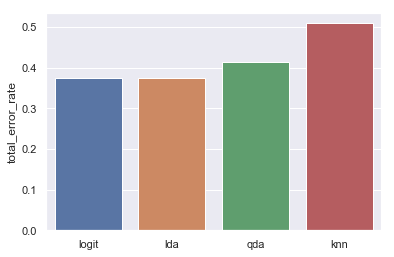

In [137]:
ax = sns.barplot(x=results.index, y=results['total_error_rate'])

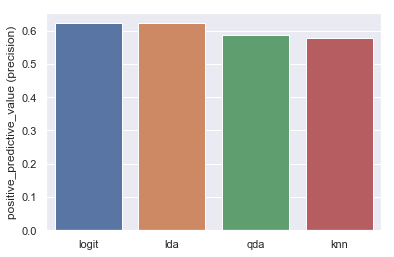

In [150]:
ax = sns.barplot(x=results.index, y=results['positive_predictive_value (precision)'])

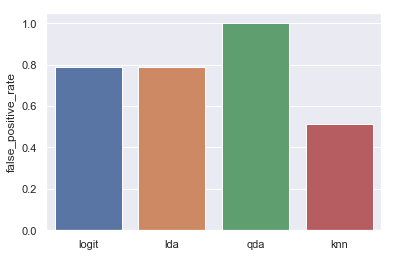

In [151]:
ax = sns.barplot(x=results.index, y=results['false_positive_rate'])

Logistic regression and LDA provide the best results in terms of oeverall error rate. That is, they make the lowest number of incorrect predictions overall. These models produce an total error rate of 37.5% which is better than the naive approach of assuming all results are positive which would yield 41.3% error rate. These models also exhibit the highest precision, that is a higher proportion of positive predictions are correct. 

With a total error rate of 50.9% KNN performs worse than a naive approach overall, but it is superior in terms of specificity. Therefore knn might be prefered if we wanted to minimise false positive predictions.

In terms of predicting which stocks to invest in, we are most concerned with the precision of our model, e.g. what poroportion of stocks we invest in actually return dividends. Therefore LDA or Logistic Regression seem like the best choices.

### (i) Experiment with different combinations of predictors, includ- ing possible transformations and interactions, for each of the methods. Report the variables, method, and associated confu- sion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.